데이터 설명

-     대전지역에서 측정한 실내외 19곳의 센서데이터와, 주변 지역의 기상청 공공데이터를 semi-비식별화하여 제공합니다.

-     센서는 온도를 측정하였습니다.

-     모든 데이터는 시간 순으로 정렬 되어 있으며 10분 단위 데이터 입니다.

-     예측 대상(target variable)은 Y18입니다.



train.csv 

-     30일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y00~Y17)

-     이후 3일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y18)



test.csv 

-     train.csv 기간 이후 80일 간의 기상청 데이터 (X00~X39)



sample_submission.csv

-     제출 양식 예시

In [0]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

In [2]:
import os
from pathlib import Path

# folder 변수에 구글드라이브에 프로젝트를 저장한 디렉토리를 입력하세요!
# My Drive 밑에 저장했다면 그대로 두시면 됩니다.
folder = "AIFrenz_Season1_dataset"
project_dir = ""

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive/AIFrenz_Season1_dataset


In [0]:
#!pip install tensorflow-gpu==2.0.0

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


from IPython.display import clear_output

import os
import time
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

tensorflow version: 2.2.0-rc2
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU 사용 가능 여부: False


In [0]:
raw_train_data = pd.read_csv('./train.csv')
raw_submit_data = pd.read_csv('./test.csv')
submission_data = pd.read_csv('./sample_submission.csv')

raw_train_data = raw_train_data.astype(np.float32)
raw_submit_data = raw_submit_data.astype(np.float32)
submission_data = submission_data.astype(np.float32)

In [0]:
data=raw_train_data.iloc[0:4320]
label = data['Y05']
data=data.drop(data.columns[range(41,len(data.columns))],axis='columns')
del data['id']

In [7]:
data

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,9.700000,988.799988,1.2,0.6,0.0,1009.299988,989.599976,12.200000,1009.900024,1009.799988,0.0,0.00,82.400002,71.300003,0.0,101.099998,0.0,56.099998,0.3,0.0,91.000000,0.0,1002.500000,1009.799988,1.1,2.300000,0.5,1008.700012,12.300000,1001.599976,69.099998,8.200000,10.7,1010.099976,0.00,256.399994,0.0,77.199997,62.599998,0.0
1,9.300000,988.900024,1.7,1.9,0.0,1009.299988,989.599976,12.100000,1010.000000,1009.900024,0.0,0.00,81.199997,121.800003,0.0,165.300003,0.0,0.000000,0.4,0.0,91.900002,0.0,1002.500000,1009.900024,0.0,0.000000,0.0,1008.700012,12.100000,1001.700012,70.300003,8.300000,10.3,1010.099976,0.00,215.399994,0.0,77.300003,63.500000,0.0
2,9.400000,989.000000,1.1,2.3,0.0,1009.200012,989.700012,12.100000,1010.099976,1010.099976,0.0,0.00,86.099998,232.000000,0.0,144.000000,0.0,0.000000,0.6,0.0,93.300003,0.0,1002.400024,1009.799988,0.0,0.000000,0.0,1008.599976,12.100000,1001.599976,71.500000,8.000000,9.7,1010.000000,0.00,235.199997,0.0,77.300003,63.900002,0.0
3,9.400000,988.900024,1.5,0.7,0.0,1009.200012,989.599976,12.000000,1010.000000,1010.000000,0.0,0.00,87.699997,0.000000,0.0,115.900002,0.0,294.100006,0.1,0.0,93.400002,0.0,1002.400024,1009.700012,0.0,0.000000,0.2,1008.700012,12.100000,1001.500000,73.199997,7.700000,9.4,1010.099976,0.00,214.000000,0.0,77.500000,64.500000,0.0
4,9.200000,988.900024,0.8,1.7,0.0,1009.200012,989.700012,12.000000,1010.099976,1010.000000,0.0,0.00,88.900002,0.000000,0.0,124.699997,0.0,0.000000,0.0,0.0,94.099998,0.0,1002.400024,1009.700012,0.0,0.000000,0.0,1008.700012,12.000000,1001.500000,74.300003,7.400000,9.4,1010.099976,0.00,174.899994,0.0,78.000000,65.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,19.500000,987.799988,1.7,0.4,0.0,1007.799988,988.000000,21.299999,1007.799988,1007.500000,0.0,13.21,92.000000,227.500000,0.0,304.000000,0.0,10.700000,0.4,0.0,84.099998,0.0,1001.200012,1008.200012,0.4,328.399994,0.6,1006.599976,21.600000,1000.099976,82.300003,18.799999,19.4,1008.200012,16.68,272.899994,0.0,82.300003,74.300003,0.0
4316,19.299999,987.700012,2.1,0.9,0.0,1007.799988,988.099976,21.299999,1008.000000,1007.400024,0.0,13.21,92.000000,259.399994,0.0,309.100006,0.0,0.700000,0.3,0.0,85.699997,0.0,1001.200012,1008.200012,0.2,346.700012,1.1,1006.799988,21.600000,1000.099976,85.800003,18.600000,18.5,1008.400024,16.68,315.899994,0.0,82.400002,74.800003,0.0
4317,19.500000,987.799988,0.9,1.3,0.0,1007.799988,988.299988,21.200001,1008.099976,1007.500000,0.0,13.21,91.900002,256.100006,0.0,318.600006,0.0,54.700001,0.9,0.0,85.900002,0.0,1001.200012,1008.299988,0.9,342.100006,0.5,1006.799988,21.500000,1000.200012,84.099998,18.400000,19.1,1008.400024,16.68,343.299988,0.0,82.800003,75.400002,0.0
4318,20.000000,987.799988,1.4,0.5,0.0,1007.799988,988.299988,21.100000,1008.099976,1007.500000,0.0,13.21,92.099998,203.899994,0.0,327.700012,0.0,116.099998,0.4,0.0,83.699997,0.0,1001.200012,1008.099976,0.7,345.500000,0.5,1006.799988,21.299999,1000.000000,85.400002,18.200001,19.0,1008.400024,16.68,341.700012,0.0,82.800003,75.800003,0.0


In [6]:
data.columns[data.std(axis=0)==0]

Index(['X14', 'X16', 'X19'], dtype='object')

In [0]:
del data['X14']
del data['X16']
del data['X19']

In [0]:
submit_data = raw_submit_data
del submit_data['id']
del submit_data['X14']
del submit_data['X16']
del submit_data['X19']

In [0]:
submit_data = submit_data.astype(np.float32)


In [10]:
submit_data

array([[1.870e+01, 9.874e+02, 1.500e+00, ..., 8.400e+01, 5.990e+01,
        0.000e+00],
       [1.880e+01, 9.874e+02, 1.100e+00, ..., 8.400e+01, 6.050e+01,
        0.000e+00],
       [1.900e+01, 9.874e+02, 1.300e+00, ..., 8.500e+01, 6.080e+01,
        0.000e+00],
       ...,
       [2.560e+01, 9.932e+02, 3.800e+00, ..., 7.920e+01, 6.830e+01,
        5.000e-01],
       [2.550e+01, 9.932e+02, 2.400e+00, ..., 8.010e+01, 6.880e+01,
        5.000e-01],
       [2.540e+01, 9.932e+02, 3.000e+00, ..., 8.020e+01, 6.890e+01,
        5.000e-01]], dtype=float32)

In [11]:
data

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,9.700000,988.799988,1.2,0.6,0.0,1009.299988,989.599976,12.200000,1009.900024,1009.799988,0.0,0.00,82.400002,71.300003,101.099998,56.099998,0.3,91.000000,0.0,1002.500000,1009.799988,1.1,2.300000,0.5,1008.700012,12.300000,1001.599976,69.099998,8.200000,10.7,1010.099976,0.00,256.399994,0.0,77.199997,62.599998,0.0
1,9.300000,988.900024,1.7,1.9,0.0,1009.299988,989.599976,12.100000,1010.000000,1009.900024,0.0,0.00,81.199997,121.800003,165.300003,0.000000,0.4,91.900002,0.0,1002.500000,1009.900024,0.0,0.000000,0.0,1008.700012,12.100000,1001.700012,70.300003,8.300000,10.3,1010.099976,0.00,215.399994,0.0,77.300003,63.500000,0.0
2,9.400000,989.000000,1.1,2.3,0.0,1009.200012,989.700012,12.100000,1010.099976,1010.099976,0.0,0.00,86.099998,232.000000,144.000000,0.000000,0.6,93.300003,0.0,1002.400024,1009.799988,0.0,0.000000,0.0,1008.599976,12.100000,1001.599976,71.500000,8.000000,9.7,1010.000000,0.00,235.199997,0.0,77.300003,63.900002,0.0
3,9.400000,988.900024,1.5,0.7,0.0,1009.200012,989.599976,12.000000,1010.000000,1010.000000,0.0,0.00,87.699997,0.000000,115.900002,294.100006,0.1,93.400002,0.0,1002.400024,1009.700012,0.0,0.000000,0.2,1008.700012,12.100000,1001.500000,73.199997,7.700000,9.4,1010.099976,0.00,214.000000,0.0,77.500000,64.500000,0.0
4,9.200000,988.900024,0.8,1.7,0.0,1009.200012,989.700012,12.000000,1010.099976,1010.000000,0.0,0.00,88.900002,0.000000,124.699997,0.000000,0.0,94.099998,0.0,1002.400024,1009.700012,0.0,0.000000,0.0,1008.700012,12.000000,1001.500000,74.300003,7.400000,9.4,1010.099976,0.00,174.899994,0.0,78.000000,65.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,19.500000,987.799988,1.7,0.4,0.0,1007.799988,988.000000,21.299999,1007.799988,1007.500000,0.0,13.21,92.000000,227.500000,304.000000,10.700000,0.4,84.099998,0.0,1001.200012,1008.200012,0.4,328.399994,0.6,1006.599976,21.600000,1000.099976,82.300003,18.799999,19.4,1008.200012,16.68,272.899994,0.0,82.300003,74.300003,0.0
4316,19.299999,987.700012,2.1,0.9,0.0,1007.799988,988.099976,21.299999,1008.000000,1007.400024,0.0,13.21,92.000000,259.399994,309.100006,0.700000,0.3,85.699997,0.0,1001.200012,1008.200012,0.2,346.700012,1.1,1006.799988,21.600000,1000.099976,85.800003,18.600000,18.5,1008.400024,16.68,315.899994,0.0,82.400002,74.800003,0.0
4317,19.500000,987.799988,0.9,1.3,0.0,1007.799988,988.299988,21.200001,1008.099976,1007.500000,0.0,13.21,91.900002,256.100006,318.600006,54.700001,0.9,85.900002,0.0,1001.200012,1008.299988,0.9,342.100006,0.5,1006.799988,21.500000,1000.200012,84.099998,18.400000,19.1,1008.400024,16.68,343.299988,0.0,82.800003,75.400002,0.0
4318,20.000000,987.799988,1.4,0.5,0.0,1007.799988,988.299988,21.100000,1008.099976,1007.500000,0.0,13.21,92.099998,203.899994,327.700012,116.099998,0.4,83.699997,0.0,1001.200012,1008.099976,0.7,345.500000,0.5,1006.799988,21.299999,1000.000000,85.400002,18.200001,19.0,1008.400024,16.68,341.700012,0.0,82.800003,75.800003,0.0


In [0]:
label

0       10.5
1       10.0
2       10.0
3        9.5
4        9.5
        ... 
4315    21.0
4316    21.0
4317    21.0
4318    20.5
4319    20.5
Name: Y05, Length: 4320, dtype: float32

In [0]:
train_data, test_data, train_label, test_label=train_test_split(data, label, test_size=0.2, shuffle =False)

In [0]:
train_data

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,9.700000,988.799988,1.2,0.6,0.0,1009.299988,989.599976,12.200000,1009.900024,1009.799988,0.0,0.00,82.400002,71.300003,101.099998,56.099998,0.3,91.000000,0.0,1002.500000,1009.799988,1.1,2.300000,0.5,1008.700012,12.300000,1001.599976,69.099998,8.200000,10.700000,1010.099976,0.00,256.399994,0.0,77.199997,62.599998,0.0
1,9.300000,988.900024,1.7,1.9,0.0,1009.299988,989.599976,12.100000,1010.000000,1009.900024,0.0,0.00,81.199997,121.800003,165.300003,0.000000,0.4,91.900002,0.0,1002.500000,1009.900024,0.0,0.000000,0.0,1008.700012,12.100000,1001.700012,70.300003,8.300000,10.300000,1010.099976,0.00,215.399994,0.0,77.300003,63.500000,0.0
2,9.400000,989.000000,1.1,2.3,0.0,1009.200012,989.700012,12.100000,1010.099976,1010.099976,0.0,0.00,86.099998,232.000000,144.000000,0.000000,0.6,93.300003,0.0,1002.400024,1009.799988,0.0,0.000000,0.0,1008.599976,12.100000,1001.599976,71.500000,8.000000,9.700000,1010.000000,0.00,235.199997,0.0,77.300003,63.900002,0.0
3,9.400000,988.900024,1.5,0.7,0.0,1009.200012,989.599976,12.000000,1010.000000,1010.000000,0.0,0.00,87.699997,0.000000,115.900002,294.100006,0.1,93.400002,0.0,1002.400024,1009.700012,0.0,0.000000,0.2,1008.700012,12.100000,1001.500000,73.199997,7.700000,9.400000,1010.099976,0.00,214.000000,0.0,77.500000,64.500000,0.0
4,9.200000,988.900024,0.8,1.7,0.0,1009.200012,989.700012,12.000000,1010.099976,1010.000000,0.0,0.00,88.900002,0.000000,124.699997,0.000000,0.0,94.099998,0.0,1002.400024,1009.700012,0.0,0.000000,0.0,1008.700012,12.000000,1001.500000,74.300003,7.400000,9.400000,1010.099976,0.00,174.899994,0.0,78.000000,65.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,21.000000,989.200012,0.9,0.6,0.0,1008.700012,989.900024,22.400000,1009.700012,1008.900024,0.0,28.75,74.699997,0.000000,202.100006,0.000000,0.0,76.199997,0.0,1002.200012,1009.700012,0.7,294.200012,0.0,1008.400024,22.700001,1001.700012,75.199997,20.400000,20.600000,1010.000000,29.92,253.899994,0.0,65.000000,56.500000,0.0
3452,21.100000,989.200012,0.9,1.4,0.0,1008.900024,989.799988,22.500000,1009.700012,1008.900024,0.0,28.75,75.900002,317.600006,179.399994,132.600006,0.7,75.500000,0.0,1002.400024,1009.700012,0.0,0.000000,1.0,1008.200012,22.700001,1001.700012,74.900002,20.200001,20.500000,1009.799988,29.92,247.100006,0.0,69.400002,56.299999,0.0
3453,20.799999,989.200012,1.5,1.9,0.0,1009.000000,989.799988,22.400000,1009.599976,1009.000000,0.0,28.75,77.900002,65.800003,134.100006,78.099998,0.6,79.199997,0.0,1002.500000,1009.599976,1.7,304.600006,1.5,1008.000000,22.600000,1001.599976,70.800003,19.799999,20.900000,1009.599976,29.92,243.500000,0.0,73.500000,56.400002,0.0
3454,20.799999,989.099976,1.3,1.7,0.0,1009.099976,989.799988,22.299999,1009.599976,1008.900024,0.0,28.75,78.000000,354.700012,148.199997,133.600006,0.9,77.699997,0.0,1002.500000,1009.599976,1.1,314.299988,1.5,1008.000000,22.200001,1001.599976,70.000000,19.799999,20.900000,1009.599976,29.92,249.100006,0.0,74.199997,58.900002,0.0


In [0]:
train_label

0       10.5
1       10.0
2       10.0
3        9.5
4        9.5
        ... 
3451    22.0
3452    22.0
3453    22.0
3454    22.0
3455    21.5
Name: Y05, Length: 3456, dtype: float32

In [0]:
test_data

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
3456,20.500000,989.099976,1.8,1.1,0.0,1008.900024,989.599976,22.100000,1009.500000,1008.700012,0.0,0.00,80.199997,4.900000,153.000000,117.599998,0.9,77.800003,0.0,1002.299988,1009.400024,1.1,292.200012,0.8,1007.900024,21.700001,1001.299988,72.500000,19.400000,20.299999,1009.500000,0.00,243.699997,0.0,74.800003,60.299999,0.0
3457,20.299999,989.000000,1.2,1.6,0.0,1008.700012,989.400024,22.000000,1009.299988,1008.599976,0.0,0.00,80.900002,0.000000,160.199997,135.800003,0.0,77.900002,0.0,1002.099976,1009.200012,0.3,282.700012,2.1,1007.799988,21.700001,1001.099976,73.500000,19.299999,20.200001,1009.400024,0.00,261.399994,0.0,75.000000,60.299999,0.0
3458,20.200001,988.799988,1.6,1.3,0.0,1008.500000,989.400024,21.900000,1009.299988,1008.400024,0.0,0.00,78.400002,4.100000,165.899994,132.399994,1.2,78.000000,0.0,1001.900024,1009.200012,0.0,0.000000,1.5,1007.799988,21.600000,1001.099976,75.699997,19.400000,20.000000,1009.400024,0.00,249.399994,0.0,75.000000,60.599998,0.0
3459,20.200001,988.799988,1.1,0.0,0.0,1008.299988,989.200012,21.799999,1009.099976,1008.400024,0.0,0.00,78.099998,17.500000,152.100006,140.899994,1.0,78.500000,0.0,1001.700012,1009.099976,0.0,0.000000,1.1,1007.799988,21.700001,1001.000000,78.800003,19.299999,19.900000,1009.400024,0.00,0.000000,0.0,74.900002,60.900002,0.0
3460,20.100000,988.700012,1.4,0.0,0.0,1008.400024,989.200012,21.700001,1009.099976,1008.400024,0.0,0.00,80.400002,15.800000,153.600006,128.600006,1.2,77.500000,0.0,1001.799988,1009.000000,0.0,0.000000,2.4,1007.799988,21.600000,1000.900024,80.300003,19.000000,19.700001,1009.400024,0.00,0.000000,0.0,75.400002,60.200001,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,19.500000,987.799988,1.7,0.4,0.0,1007.799988,988.000000,21.299999,1007.799988,1007.500000,0.0,13.21,92.000000,227.500000,304.000000,10.700000,0.4,84.099998,0.0,1001.200012,1008.200012,0.4,328.399994,0.6,1006.599976,21.600000,1000.099976,82.300003,18.799999,19.400000,1008.200012,16.68,272.899994,0.0,82.300003,74.300003,0.0
4316,19.299999,987.700012,2.1,0.9,0.0,1007.799988,988.099976,21.299999,1008.000000,1007.400024,0.0,13.21,92.000000,259.399994,309.100006,0.700000,0.3,85.699997,0.0,1001.200012,1008.200012,0.2,346.700012,1.1,1006.799988,21.600000,1000.099976,85.800003,18.600000,18.500000,1008.400024,16.68,315.899994,0.0,82.400002,74.800003,0.0
4317,19.500000,987.799988,0.9,1.3,0.0,1007.799988,988.299988,21.200001,1008.099976,1007.500000,0.0,13.21,91.900002,256.100006,318.600006,54.700001,0.9,85.900002,0.0,1001.200012,1008.299988,0.9,342.100006,0.5,1006.799988,21.500000,1000.200012,84.099998,18.400000,19.100000,1008.400024,16.68,343.299988,0.0,82.800003,75.400002,0.0
4318,20.000000,987.799988,1.4,0.5,0.0,1007.799988,988.299988,21.100000,1008.099976,1007.500000,0.0,13.21,92.099998,203.899994,327.700012,116.099998,0.4,83.699997,0.0,1001.200012,1008.099976,0.7,345.500000,0.5,1006.799988,21.299999,1000.000000,85.400002,18.200001,19.000000,1008.400024,16.68,341.700012,0.0,82.800003,75.800003,0.0


In [0]:
test_label

3456    21.5
3457    21.5
3458    21.0
3459    21.0
3460    21.0
        ... 
4315    21.0
4316    21.0
4317    21.0
4318    20.5
4319    20.5
Name: Y05, Length: 864, dtype: float32

In [0]:
train_data=train_data.to_numpy()
train_label=train_label.to_numpy()
test_data=test_data.to_numpy()
test_label=test_label.to_numpy()
submit_data = submit_data.to_numpy()

In [16]:
train_data

array([[  9.7, 988.8,   1.2, ...,  77.2,  62.6,   0. ],
       [  9.3, 988.9,   1.7, ...,  77.3,  63.5,   0. ],
       [  9.4, 989. ,   1.1, ...,  77.3,  63.9,   0. ],
       ...,
       [ 20.8, 989.2,   1.5, ...,  73.5,  56.4,   0. ],
       [ 20.8, 989.1,   1.3, ...,  74.2,  58.9,   0. ],
       [ 20.6, 989.1,   1.2, ...,  74.4,  59.3,   0. ]], dtype=float32)

In [17]:
raw_submit_data

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,18.700001,987.400024,1.5,1.3,0.0,1006.799988,987.700012,21.100000,1007.500000,1007.200012,0.0,0.0,96.099998,333.600006,199.600006,36.000000,1.1,94.699997,0.0,1000.299988,1007.599976,0.0,0.000000,0.1,1006.000000,23.200001,999.500000,91.400002,17.500000,19.200001,1007.599976,0.000000,194.699997,0.0,84.000000,59.900002,0.0
1,18.799999,987.400024,1.1,1.2,0.0,1006.700012,987.700012,21.200001,1007.500000,1007.200012,0.0,0.0,96.199997,335.500000,194.000000,127.699997,0.6,95.300003,0.0,1000.200012,1007.500000,0.0,0.000000,0.3,1005.900024,23.100000,999.400024,91.599998,17.400000,19.100000,1007.500000,0.000000,173.100006,0.0,84.000000,60.500000,0.0
2,19.000000,987.400024,1.3,1.2,0.0,1006.599976,987.599976,21.200001,1007.400024,1007.200012,0.0,0.0,96.400002,0.000000,172.899994,59.000000,0.0,93.900002,0.0,1000.099976,1007.400024,0.0,0.000000,0.7,1005.900024,23.100000,999.299988,92.000000,17.200001,19.000000,1007.500000,0.000000,208.600006,0.0,85.000000,60.799999,0.0
3,18.700001,987.400024,2.3,0.8,0.0,1006.599976,987.599976,21.100000,1007.400024,1007.200012,0.0,0.0,96.500000,252.899994,153.500000,54.900002,0.4,94.400002,0.0,1000.099976,1007.400024,0.0,0.000000,0.6,1005.799988,22.799999,999.299988,93.000000,17.200001,18.799999,1007.400024,0.000000,185.000000,0.0,85.800003,61.200001,0.0
4,18.400000,987.400024,1.1,0.7,0.0,1006.700012,987.700012,20.900000,1007.500000,1007.200012,0.0,0.0,96.599998,238.199997,173.800003,48.799999,0.8,95.699997,0.0,1000.200012,1007.299988,0.0,0.000000,0.7,1005.900024,22.799999,999.200012,92.300003,17.400000,18.900000,1007.500000,0.000000,162.800003,0.0,87.300003,61.700001,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,25.700001,993.200012,3.9,3.8,0.0,1011.700012,993.799988,26.299999,1013.299988,1012.599976,0.0,17.1,88.099998,65.599998,101.599998,176.699997,1.8,77.300003,0.0,1005.200012,1012.900024,1.6,169.800003,4.5,1011.500000,27.700001,1004.900024,76.599998,23.600000,24.400000,1013.000000,19.559999,169.600006,0.0,79.699997,67.500000,0.5
11516,25.600000,993.200012,3.0,3.0,0.0,1011.700012,993.799988,26.299999,1013.299988,1012.599976,0.0,17.1,75.500000,51.900002,84.800003,187.800003,2.9,78.099998,0.0,1005.200012,1012.900024,1.9,138.899994,4.7,1011.400024,27.600000,1004.900024,76.699997,25.299999,24.400000,1012.900024,19.559999,175.899994,0.0,79.599998,67.900002,0.5
11517,25.600000,993.200012,3.8,2.5,0.0,1011.900024,993.700012,26.200001,1013.200012,1012.700012,0.0,17.1,77.500000,29.000000,104.500000,184.800003,2.9,78.900002,0.0,1005.400024,1013.000000,2.3,146.699997,4.8,1011.400024,27.500000,1005.000000,77.099998,24.900000,24.299999,1012.900024,19.559999,204.699997,0.0,79.199997,68.300003,0.5
11518,25.500000,993.200012,2.4,2.8,0.0,1011.799988,993.700012,26.100000,1013.200012,1012.599976,0.0,17.1,74.099998,30.000000,103.000000,187.800003,3.4,79.699997,0.0,1005.299988,1013.000000,1.7,146.500000,3.5,1011.400024,27.299999,1005.000000,77.300003,25.299999,24.200001,1012.900024,19.559999,174.199997,0.0,80.099998,68.800003,0.5


In [14]:
train_data

array([[  9.7, 988.8,   1.2, ...,  77.2,  62.6,   0. ],
       [  9.3, 988.9,   1.7, ...,  77.3,  63.5,   0. ],
       [  9.4, 989. ,   1.1, ...,  77.3,  63.9,   0. ],
       ...,
       [ 20.8, 989.2,   1.5, ...,  73.5,  56.4,   0. ],
       [ 20.8, 989.1,   1.3, ...,  74.2,  58.9,   0. ],
       [ 20.6, 989.1,   1.2, ...,  74.4,  59.3,   0. ]], dtype=float32)

In [0]:
train_label

array([10.5, 10. , 10. , ..., 22. , 22. , 21.5], dtype=float32)

In [0]:
test_data

array([[2.050e+01, 9.891e+02, 1.800e+00, ..., 7.480e+01, 6.030e+01,
        0.000e+00],
       [2.030e+01, 9.890e+02, 1.200e+00, ..., 7.500e+01, 6.030e+01,
        0.000e+00],
       [2.020e+01, 9.888e+02, 1.600e+00, ..., 7.500e+01, 6.060e+01,
        0.000e+00],
       ...,
       [1.950e+01, 9.878e+02, 9.000e-01, ..., 8.280e+01, 7.540e+01,
        0.000e+00],
       [2.000e+01, 9.878e+02, 1.400e+00, ..., 8.280e+01, 7.580e+01,
        0.000e+00],
       [2.010e+01, 9.878e+02, 1.200e+00, ..., 8.350e+01, 7.690e+01,
        0.000e+00]], dtype=float32)

In [0]:
test_label

array([21.5, 21.5, 21. , 21. , 21. , 21. , 20.5, 20.5, 20.5, 20.5, 20.5,
       20.5, 20. , 20. , 20. , 20. , 20. , 20. , 19.5, 19.5, 19.5, 19.5,
       19. , 19. , 19. , 19. , 19. , 19. , 19. , 19. , 19. , 19. , 19. ,
       19. , 19. , 19. , 19. , 19.5, 19.5, 20. , 20. , 20.5, 20.5, 20.5,
       20.5, 21. , 21.5, 21.5, 22. , 22. , 23. , 23.5, 23.5, 24. , 24. ,
       24.5, 24.5, 25. , 25.5, 26. , 27. , 28. , 29.5, 30. , 30.5, 30.5,
       30. , 30.5, 31. , 31.5, 31. , 30.5, 31. , 32. , 32.5, 32.5, 32.5,
       33. , 33. , 32.5, 32. , 31.5, 31. , 31. , 31. , 31. , 30.5, 30.5,
       30.5, 31. , 31. , 30. , 29.5, 28.5, 28.5, 28.5, 28. , 28. , 28. ,
       27.5, 27.5, 27. , 27. , 26.5, 26.5, 27. , 27.5, 28. , 27. , 26.5,
       26.5, 26.5, 26. , 26. , 25.5, 24.5, 24. , 23. , 22.5, 22. , 22. ,
       21.5, 21. , 21. , 20.5, 20.5, 20.5, 20. , 20. , 20. , 20. , 19.5,
       19.5, 19.5, 19.5, 19. , 19. , 19. , 19. , 19. , 19. , 18.5, 18.5,
       18.5, 18.5, 18.5, 18.5, 18. , 18. , 18. , 18

# dataset

In [0]:
def make_dataset(data,label,data_mean=None, data_std=None,label_mean=None, label_std=None,mode='train',seq_length=432, target_delay=10, strides=4):
    assert mode in ['train', 'test']
    if mode is not 'train':
        if data_mean is None or data_std is None:
            print('Current mode is {}'.format(mode))
            print('This mode needs mean and std of train data')
            assert False


    if mode is 'train':
        data_mean = np.mean(data,axis=0)
        data_std = np.std(data,axis=0)
        label_mean = np.mean(label,axis=0)
        label_std = np.std(label,axis=0)
        
    else:
        data_mean = data_mean
        data_std = data_std
        label_mean = label_mean
        label_std = label_std

    data = (data-data_mean) / data_std
    label = (label-label_mean) / label_std
    
    
    sequence = []
    target = []
    for index in range(len(data) - seq_length - target_delay):
        if index % strides == 0:  
            sequence.append(data[index:index+seq_length])    # 위의 설명 2-1 을 참고하여 None을 채우세요.
            target.append(label[index+seq_length+target_delay])
    
    if mode is 'train':
        return np.array(sequence), np.array(target), data_mean, data_std, label_mean, label_std
    else:
        return np.array(sequence), np.array(target)


In [0]:
train_sequences, train_labels, train_data_mean, train_data_std, train_label_mean,train_label_std=make_dataset(data=train_data,label=train_label, mode='train')

test_sequences,test_labels = make_dataset(data=test_data,label=test_label,mode="test",
                         data_mean=train_data_mean, data_std=train_data_std,
                         label_mean=train_label_mean,label_std=train_label_std)
submit_data_normal=(submit_data - train_data_mean) / train_data_std

In [0]:
train_sequences

In [0]:
train_labels

In [0]:
test_sequences

In [0]:
test_labels

# hyperparameter

In [0]:
batch_size = 128
max_epochs = 20
learning_rate = 3e-5
hidden_sizes = [100,100] # hidden_sizes must be a list

In [0]:
N = BUFFER_SIZE = len(train_sequences)
train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_sequences, test_labels))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

In [0]:
reshape_submit=submit_data_normal.reshape(-1,1,37)

In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(160, activation='relu',input_shape=(432,37)))
model.add(tf.keras.layers.Dense(80,activation='relu'))
model.add(tf.keras.layers.Dense(50,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='linear'))


In [47]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 432, 160)          6080      
_________________________________________________________________
dense_15 (Dense)             (None, 432, 80)           12880     
_________________________________________________________________
dense_16 (Dense)             (None, 432, 50)           4050      
_________________________________________________________________
dense_17 (Dense)             (None, 432, 1)            51        
Total params: 23,061
Trainable params: 23,061
Non-trainable params: 0
_________________________________________________________________


In [0]:
## 코드 시작 ##
model.compile(loss=tf.keras.losses.MeanSquaredError(), 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate), 
              metrics=['mse'])
## 코드 종료 ##

In [49]:
train_dataset

<RepeatDataset shapes: ((None, 432, 37), (None,)), types: (tf.float32, tf.float32)>

In [50]:
model.fit(train_dataset, steps_per_epoch = (len(train_data)/batch_size), 
          validation_data = test_dataset, 
          validation_steps= len(test_data)/batch_size,
          epochs= max_epochs,
)

Epoch 1/20
27/27 [==============================] - 6s 212ms/step - loss: 1.1007 - mse: 1.1009 - val_loss: 0.5355 - val_mse: 0.5355
Epoch 2/20
27/27 [==============================] - 6s 209ms/step - loss: 0.9935 - mse: 0.9918 - val_loss: 0.5123 - val_mse: 0.5123
Epoch 3/20
27/27 [==============================] - 6s 206ms/step - loss: 0.9585 - mse: 0.9583 - val_loss: 0.5127 - val_mse: 0.5127
Epoch 4/20
27/27 [==============================] - 6s 208ms/step - loss: 0.9399 - mse: 0.9397 - val_loss: 0.5157 - val_mse: 0.5157
Epoch 5/20
27/27 [==============================] - 6s 209ms/step - loss: 0.9211 - mse: 0.9207 - val_loss: 0.5174 - val_mse: 0.5174
Epoch 6/20
27/27 [==============================] - 6s 206ms/step - loss: 0.9411 - mse: 0.9407 - val_loss: 0.5183 - val_mse: 0.5183
Epoch 7/20
27/27 [==============================] - 6s 208ms/step - loss: 0.9280 - mse: 0.9286 - val_loss: 0.5188 - val_mse: 0.5188
Epoch 8/20
27/27 [==============================] - 6s 206ms/step - loss: 0.

# Prediction

In [51]:
pred=model.predict(reshape_submit,batch_size=batch_size)
pred=pred*(train_label_std)+train_label_mean

In [59]:
pred=pred.reshape(-1)
pred

array([26.07781 , 25.460443, 25.096895, ..., 21.371626, 22.858646,
       21.269398], dtype=float32)

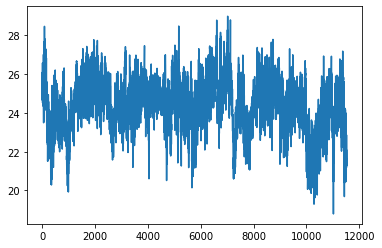

In [60]:
plt.plot(pred.reshape(-1))


In [0]:
submission_data['Y18']=pred

In [0]:
submission_data.to_csv('./result_relu.csv',header=True,index=False)